In [1]:
!git clone https://github.com/Abdulrasheed1729/xai.git

Cloning into 'xai'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 393 (delta 2), reused 6 (delta 2), pack-reused 384 (from 1)
Receiving objects: 100% (393/393), 43.95 MiB | 28.54 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.io import read_image
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from PIL import Image

from xai.CAV.image_processing import select_concept_images, sample_images, get_resnet_dataloader
from xai.CAV.utils import flatten, get_activations, get_grads

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [4]:
batch_size = 16
num_concept_images = 100
num_target_images = 20
target_class = "zebra"
positive_concept = "striped" #"bubbly"
negative_concept = "dotted"

Download the broden and imagenet data from: TODO

In [5]:
# Get the absolute path to concept and target images
base_dir = os.path.join(os.getcwd(), 'xai/')
concept_folder = os.path.join(base_dir, 'data', 'broden', 'dtd')
target_folder = os.path.join(base_dir, 'data', 'imagenet', target_class)

p_concept_paths = select_concept_images(folder_path=concept_folder, concept=positive_concept, n=num_concept_images)
n_concept_paths = select_concept_images(folder_path=concept_folder, concept=negative_concept, n=num_concept_images)

target_paths = sample_images(folder_path=target_folder, n=num_target_images)

In [6]:
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)
resnet.eval();

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [7]:
class_idx = ResNet18_Weights.IMAGENET1K_V1.meta["categories"].index(target_class)

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

positive_loader = get_resnet_dataloader(p_concept_paths, transform, batch_size=batch_size)
negative_loader = get_resnet_dataloader(n_concept_paths, transform, batch_size=batch_size)
target_loader = get_resnet_dataloader(target_paths, transform, batch_size=batch_size)

## Interlude: Look at data and layer

In [9]:
def look_at(image):
    img = (image - image.min()) / (image.max() - image.min())
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

torch.Size([3, 224, 224])


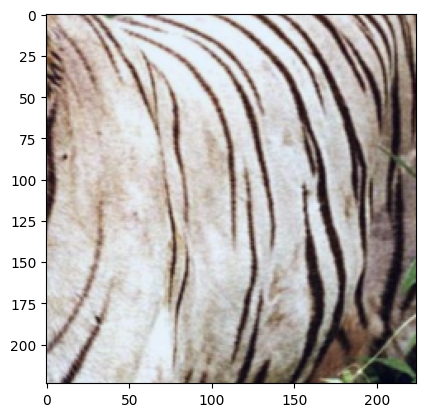

In [10]:
pos_image = next(iter(positive_loader))[7]
print(pos_image.shape)
look_at(pos_image)

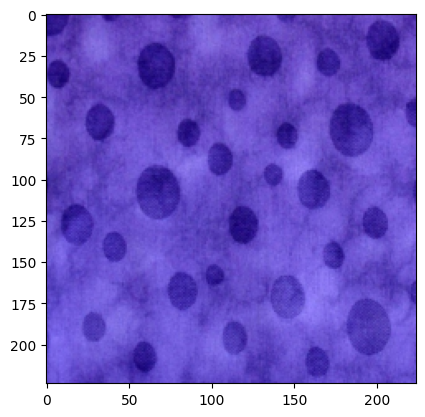

In [11]:
neg_image = next(iter(negative_loader))[7]
look_at(neg_image)

In [12]:
layer = resnet.layer4[0]
layer._modules

{'conv1': Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 'bn1': BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 'relu': ReLU(inplace=True),
 'conv2': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'bn2': BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 'downsample': Sequential(
   (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
   (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 )}

## Get activations manually

In [13]:
activations = {}
# keys = layer names (strings)
# values = activation tensors

def get_activation(name):
    # function factory for creating a hook function that captures the name of the layer it’s attached to.
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

layer_name = 'layer4'
handle = dict(resnet.named_modules())[layer_name].register_forward_hook(get_activation(layer_name))

_ = resnet(pos_image.unsqueeze(0).to(device))

handle.remove()

print(activations["layer4"].shape)

torch.Size([1, 512, 7, 7])


In [14]:
acts = activations["layer4"]
acts.view(acts.size(0), -1).numpy().shape

(1, 25088)

## Make the CAV

In [15]:
def train_cav(positive_activations, negative_activations, seed=1337):

    X = np.concatenate([positive_activations, negative_activations], axis=0)
    y = np.concatenate([np.ones(len(positive_activations)), np.zeros(len(negative_activations))])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=seed)
    #X_train, y_train = shuffle(X, y, random_state=seed)
    classifier = LogisticRegression(random_state=seed, max_iter=1000)
    classifier.fit(X_train, y_train)

    accuracy = classifier.score(X_test, y_test)
    print("Probe accuracy:", accuracy)

    cav = classifier.coef_[0]
    unit_cav = cav / np.linalg.norm(cav)

    return unit_cav

In [16]:
layer = resnet.layer4[0]

In [17]:
positive_activations = flatten(get_activations(resnet, positive_loader, device, layer))
negative_activations = flatten(get_activations(resnet, negative_loader, device, layer))

In [18]:
stripes_cav = train_cav(positive_activations, negative_activations)
#bubbly_cav = train_cav(positive_activations, negative_activations)

Probe accuracy: 1.0


In [19]:
print(stripes_cav.shape)
print(stripes_cav)

(25088,)
[-0.00053668 -0.01124271 -0.01012842 ...  0.00189509  0.00386807
  0.01140053]


## ... and calculate TCAV scores

In imagenet, zebra is class 340

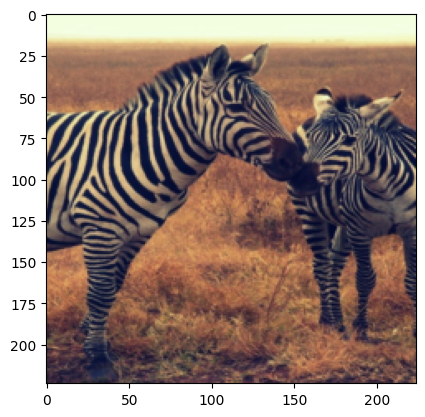

In [20]:
image = next(iter(target_loader))[5]
look_at(image)

In [21]:
def make_gradient_hook(grads):
    def bwd_hook(module, grad_input, grad_output):
        grad = grad_output[0]
        grads.append(grad.squeeze(0).detach().cpu())
    return bwd_hook

resnet.eval()
sample_input = image.unsqueeze(0).to(device)

grads = []
hook = layer.register_full_backward_hook(make_gradient_hook(grads))

resnet.zero_grad()
output = resnet(sample_input)
logits = output[0]

logit = logits[340]
logit.backward()
hook.remove()

print("Number of gradients from layer:", len(grads[0]))

Number of gradients from layer: 512


In [22]:
def tcav(cav, grads):

    directional_derivatives = np.dot(grads, cav)
    positive_counts = np.sum(directional_derivatives > 0)
    tcav_score = positive_counts / directional_derivatives.shape[0]

    return tcav_score

In [23]:
grads = flatten(get_grads(resnet, target_loader, device, layer, target_idx=340))
tcav_score = tcav(stripes_cav, grads)
#tcav_score = tcav(bubbly_cav, grads)
print(f"TCAV score: {tcav_score}")

TCAV score: 1.0


Task: Plot the probe accuracy per layer of the model.

First, modify the train_cav function to return probe accuracy.

In [24]:
def train_cav(positive_activations, negative_activations, seed=1337):

    X = np.concatenate([positive_activations, negative_activations], axis=0)
    y = np.concatenate([np.ones(len(positive_activations)), np.zeros(len(negative_activations))])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=seed)
    #X_train, y_train = shuffle(X, y, random_state=seed)
    classifier = LogisticRegression(random_state=seed, max_iter=1000)
    classifier.fit(X_train, y_train)

    accuracy = classifier.score(X_test, y_test)

    cav = classifier.coef_[0]
    unit_cav = cav / np.linalg.norm(cav)

    return unit_cav, accuracy

Loop through model to get a list of all layers

In [25]:
names, layers = [], []
for name, layer in resnet.named_children():
    names.append(name)
    layers.append(layer)
print("Number of layers:" , len(layers))

Number of layers: 10


In [26]:
names

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

Get probe accuracies for each layer and plot

In [27]:
accuracies = []
# tcavs = list()
for _layer in layers:
    _positive_activations = flatten(get_activations(resnet, positive_loader, device, _layer))
    _negative_activations = flatten(get_activations(resnet, negative_loader, device, _layer))
    _cav, _accuracy = train_cav(_positive_activations, _negative_activations)
    # _grads = flatten(get_grads(resnet, target_loader, device, _layer, target_idx=340))
    # _tcav = tcav(_cav, _grads)
    accuracies.append(_accuracy)
    # tcavs.append(_tcav)

In [28]:
# colors = plt.cm.tab10(range(len(tcavs)))
# for _i, _tcav in enumerate(tcavs):
#     plt.scatter(_i, _tcav, color=colors[_i], label=names[_i])
# plt.plot(range(len(tcavs)), tcavs)
# plt.xticks(range(len(names)), range(len(names)))
# plt.xlabel('Layer')
# plt.ylabel('TCAV Scores')
# plt.legend()
# plt.show()

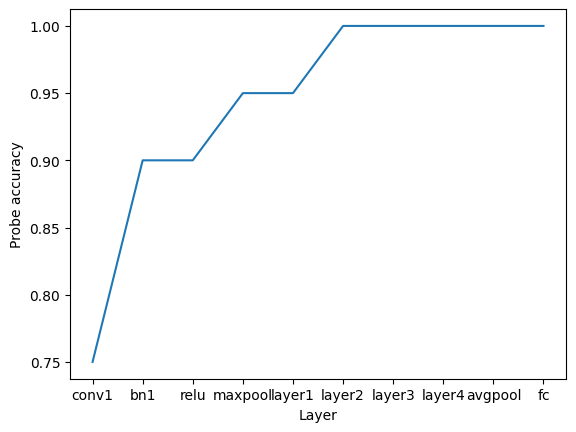

In [29]:
colors = plt.cm.tab10(range(len(accuracies)))
plt.plot(range(len(accuracies)), accuracies)
plt.xticks(range(len(names)), names)
plt.xlabel('Layer')
plt.ylabel('Probe accuracy')
plt.show()

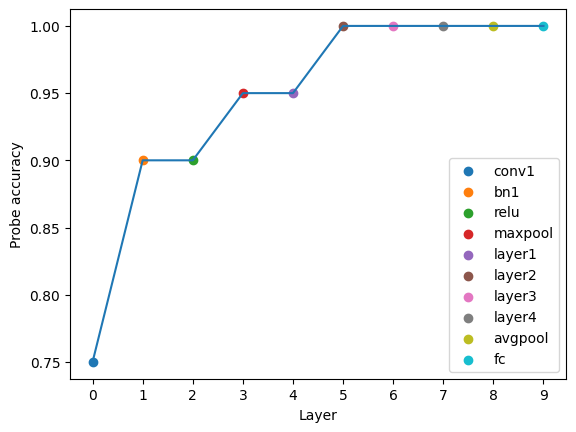

In [30]:
colors = plt.cm.tab10(range(len(accuracies)))
for _i, _acc in enumerate(accuracies):
    plt.scatter(_i, _acc, color=colors[_i], label=names[_i])
plt.plot(range(len(accuracies)), accuracies)
plt.xticks(range(len(names)), range(len(names)))
plt.xlabel('Layer')
plt.ylabel('Probe accuracy')
plt.legend()
plt.show()

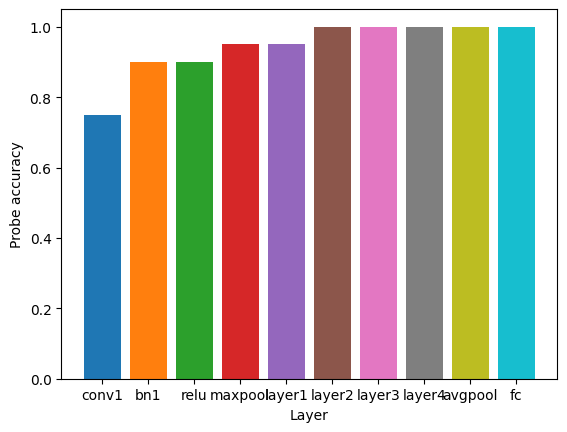

In [31]:
colors = plt.cm.tab10(range(len(accuracies)))
plt.bar(range(len(accuracies)), accuracies, color=colors)
plt.xticks(range(len(names)), names)
plt.xlabel('Layer')
plt.ylabel('Probe accuracy')
plt.show()

We can also select the layers more carefully

In [32]:
probe_layers = [resnet.conv1, resnet.layer1[0], resnet.layer2[0], resnet.layer3[0], resnet.layer4[0], resnet.fc]
probe_names = [names[0], names[4], names[5], names[6], names[7], names[9]]

In [33]:
accuracies = []
for _layer in probe_layers:
    _positive_activations = flatten(get_activations(resnet, positive_loader, device, _layer))
    _negative_activations = flatten(get_activations(resnet, negative_loader, device, _layer))
    _, _accuracy = train_cav(_positive_activations, _negative_activations)
    accuracies.append(_accuracy)

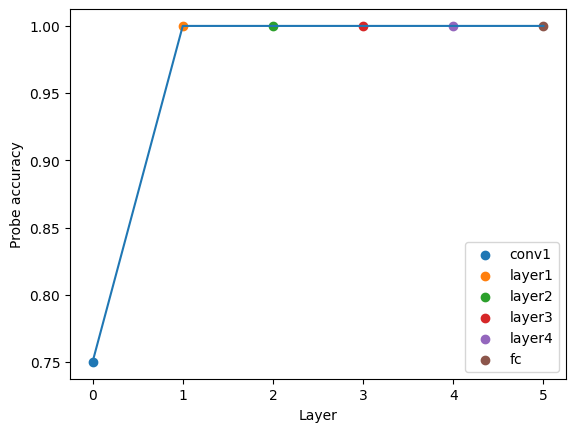

In [34]:
colors = plt.cm.tab10(range(len(accuracies)))
for _i, _acc in enumerate(accuracies):
    plt.scatter(_i, _acc, color=colors[_i], label=probe_names[_i])
plt.plot(range(len(accuracies)), accuracies)
plt.xticks(range(len(probe_names)), range(len(probe_names)))
plt.xlabel('Layer')
plt.ylabel('Probe accuracy')
plt.legend()
plt.show()

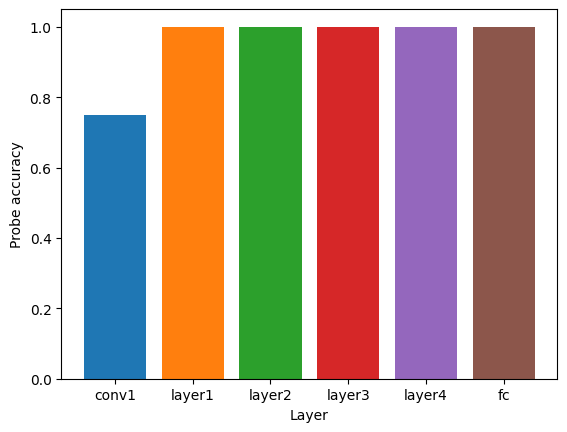

In [35]:
colors = plt.cm.tab10(range(len(accuracies)))
plt.bar(range(len(accuracies)), accuracies, color=colors)
plt.xticks(range(len(probe_names)), probe_names)
plt.xlabel('Layer')
plt.ylabel('Probe accuracy')
plt.show()

Compare the stripes CAV to the activations in the corresponding layer, for the difficult image

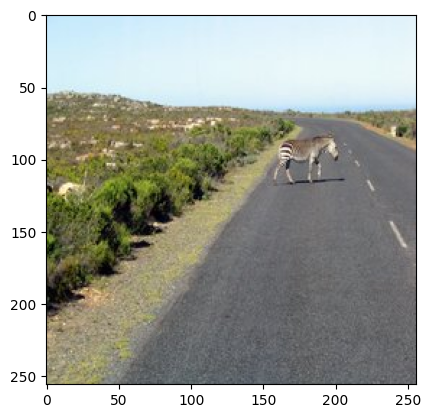

In [36]:
img = Image.open("xai/data/imagenet/volcano_zebra.jpg").convert('RGB')
plt.imshow(img)
img_tensor = transform(img)

In [37]:
resnet.eval();
resnet(img_tensor.unsqueeze(0).to(device)).argmax()

tensor(980)

In [38]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

layer_name = 'layer4'
handle = dict(resnet.named_modules())[layer_name].register_forward_hook(get_activation(layer_name))

_ = resnet(img_tensor.unsqueeze(0).to(device))

handle.remove()
mystery_activations = activations["layer4"].flatten()

In [39]:
print("Activation vector shape:", mystery_activations.shape)
print("Stripes CAV shape:", stripes_cav.shape)

Activation vector shape: torch.Size([25088])
Stripes CAV shape: (25088,)


In [40]:
from sklearn.metrics.pairwise import cosine_similarity

A cosine similarity score of 1 means that two vectors are identical, 0 means they are orthogonal (unrelated), and -1 means they are diametrically opposed.

In [41]:
cosine_similarity(mystery_activations.reshape(1, -1), stripes_cav.reshape(1, -1))

array([[0.01945796]])

In [42]:
filepath = "xai/data/imagenet/zebra/n02391049_254.JPEG"
img = read_image(filepath).float() / 255.0
look_at(img)

RuntimeError: [Errno 2] No such file or directory: 'xai/data/imagenet/zebra/n02391049_254.JPEG'

In [ ]:
resnet.eval();
resnet(img.unsqueeze(0).to(device)).argmax()

tensor(977)